In [1]:
#import library
import numpy as np
import pandas as pd
from datetime import date
from neupy import algorithms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import keras
from keras import regularizers
import pyrenn as prn
from keras.callbacks import EarlyStopping

c:\users\qqwea1223\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\qqwea1223\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\qqwea1223\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\user

In [2]:
file_parameters = ['ch', 'cv', 'cc', 'ExG', 'NDVI']
plant_date = '0401'
limit_day = 105
interval_day = 7
x_pred = range(interval_day, limit_day+1, interval_day)
path = '2016_spring/2016_spring{}.csv'
yield_path = '2016_spring/2016_spring.csv'

In [3]:
#count day after planting
def countDaysAfterPlanting(date_planted, date_key):
#     print(date_planted, date_key)
#     print(date_planting, date_key)
    f_date = date(2016, int(date_planted[:2]), int(date_planted[2:4]))
    l_date = ''.join(s for s in date_key if s.isdigit())
    #print(int('20'+l_date[:2]), int(l_date[2:4]), int(l_date[4:6]))
    l_date = date(2016, int(l_date[:2]), int(l_date[2:4]))
    return((l_date-f_date).days +1)

In [4]:
def GRNN_process(row_data, days_after_planting, x_pred, std):
#     print(row_data.shape)
#     print(days_after_planting.shape)
#     print(days_after_planting)
#     print(x_pred)
#     if (days_after_planting[0] != 0):
#         days_after_planting = np.append([0], days_after_planting, axis = 0)
#         row_data = np.append([0], row_data, axis = 0)
    grnn = algorithms.GRNN(std = std)
    grnn.train(days_after_planting, row_data)
    result = grnn.predict(x_pred)
    result = result.swapaxes(0,1)
    
#     print(result)
    return result

In [5]:
canopy_dataframe = pd.read_csv('2016_spring/2016_spring.csv')
akash_data = pd.read_excel('CH.xlsx', 'Sheet1')
index_mask = pd.read_excel('index_of_considered_samples.xlsx', 'Sheet1', header = None)

In [6]:
parameter = 'cv'
parameter_data = pd.read_csv(path.format('_'+parameter))

date_keys = parameter_data.columns

days_after_planting = np.array([countDaysAfterPlanting(plant_date, date_key) for date_key in date_keys])
print(days_after_planting)

[ 12  15  27  36  46  50  53  57  61  63  75  78  81  84  88  91  99 104
 107 110 112 116 119 124 130 134]


In [7]:
original_data = canopy_dataframe.copy()

In [8]:
def cottonYieldData(parameters):
    x_normalization_mask = []
    processed_data = {}
    std = parameters['std']
    normalization = parameters['normalization']
    interval_day = parameters['interval_day']
    limit_day = parameters['limit_day']
#     interval_process_data = np.empty([len(original_data), 0])
    x_pred = range(interval_day, limit_day+1, interval_day)
    plant_date = '0401'
    file_parameters = parameters['file_parameters']
    
    for (i, parameter) in enumerate(file_parameters):
        parameter_data = pd.read_csv(path.format('_'+parameter))
#         parameter_data = parameter_data[global_mask]
        if i == 0:
             interval_process_data = np.empty([len(parameter_data), 0])
        date_keys = parameter_data.columns
        interval_process_parameter_data = np.empty([0, len(x_pred)])
        for row in range(len(parameter_data)):      
    #         print(row)
            row_data = parameter_data.loc[row].values
            days_after_planting = np.array([countDaysAfterPlanting(plant_date, date_key) for date_key in date_keys])
            mask = days_after_planting <=limit_day
            if parameter != 'ExG':
    #             print(len(days_after_planting))
    #             print(len(mask))
                mask = (row_data>0) & mask
            row_data = row_data[mask]
            days_after_planting = days_after_planting[mask]

    #             print(days_after_planting)
    #             print(mask.shape)

            GRNN_data = GRNN_process(row_data, days_after_planting, x_pred, std)
            interval_process_parameter_data = np.append(interval_process_parameter_data, GRNN_data, axis = 0)
        x_normalization_mask.append(np.linalg.norm(interval_process_parameter_data))
        interval_process_parameter_data /= np.linalg.norm(interval_process_parameter_data)
        interval_process_data = np.append(interval_process_data, interval_process_parameter_data, axis = 1)
    
    extra_parameters = data_parameters['extra_parameters']
    for parameter in extra_parameters:
        data = original_data[[x for x in original_data.columns if parameter in x]].copy().values.astype(float)
        print(data.shape)
        x_normalization_mask.append(np.linalg.norm(data))
        data /= np.linalg.norm(data)
        interval_process_data = np.append(interval_process_data, data, axis = 1)
        
    one_hot_encoded_parameters = data_parameters['one_hot_encoded_parameters']
     #Added one hot of irrigation
    for parameter in one_hot_encoded_parameters:
        irrigation = pd.DataFrame(original_data[parameter].copy())
        irrigation_values = np.unique(irrigation)
        irrigation[parameter] = irrigation[parameter].map(lambda x: {value:i for (i, value) in enumerate(irrigation_values)}.get(x))
        irrigation = pd.get_dummies(irrigation[parameter])
        interval_process_data = np.append(interval_process_data, irrigation.values, axis = 1)    
        
#      #Added one hot of plantDate
#     test_plant_date = pd.DataFrame(yield_data['plantDate'])
#     test_plant_data_values = np.unique(yield_data['plantDate'].values)
#     test_plant_date['plantDate'] = test_plant_date['plantDate'].map(lambda x: {date:i for (i, date) in enumerate(test_plant_data_values)}.get(x))
#     test_plant_date = pd.get_dummies(test_plant_date['plantDate'])
#     interval_process_data = np.append(interval_process_data, test_plant_date.values, axis = 1)
    
        
    
    
    x_train = interval_process_data 
    y_train = original_data['Weight per row (lbs)'].copy().values
#     print(y_train.shape)
#     print(x_train.shape)
    

    y_normalization_mask = np.linalg.norm(y_train)
    if normalization:
        y_train /= y_normalization_mask

    return(x_train, y_train, x_normalization_mask, y_normalization_mask)


In [9]:
a = np.array([-1,1 , 3])
mask = np.linalg.norm(a) 
a = a.astype(float)
a /= mask
a

array([-0.30151134,  0.30151134,  0.90453403])

In [10]:
def cottonYieldDataAkash(parameters):
    canopy_dataframe = pd.read_excel('X.xlsx')
    canopy_dataframe = canopy_dataframe.reindex(np.random.permutation(canopy_dataframe.index))
    canopy_dataframe.head()
    
    x = canopy_dataframe.loc[:, canopy_dataframe.columns != 'target' ].values
#     x = canopy_dataframe[canopy_dataframe.columns[:60]].values
#     print(x.shape)
    
    y = canopy_dataframe['target'].values
#     print(y.shape)
    a = b = c = []
    return (x, y,a ,b)

In [11]:
def process(model_parameters, data_parameters, data_func):
    
    x_data, y_data, x_normalization_mask, y_normalization_mask = data_func(data_parameters)
    print(x_data.shape)
    print(y_data.shape)
    return(trainModel(x_data, y_data, x_data.shape[1], model_parameters))

In [12]:
def akashModel(x_data, y_data, input_shape, model_parameter):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state = 90)
#     x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state = 90)
    x_train = x_train.T
    y_train = y_train.T
    x_test = x_test.T
    y_test = y_test.T
    layer_shape = model_parameters['layer']
    kmax = model_parameters['k_max']
    damp_const = model_parameters['dampconst']
    damp_fac = model_parameters['dampfac']
    E_stop = model_parameters['E_stop']
    verbose = model_parameters['verbose']

    net = prn.CreateNN(np.append(np.append(input_shape, layer_shape), 1))
    net = prn.train_LM(x_train, y_train, net, verbose=verbose,
    dampfac = damp_fac, dampconst = damp_const,
    k_max=kmax, E_stop= E_stop)
    
    y = prn.NNOut(x_train, net)
    y_pred = prn.NNOut(x_test, net)
    acc_sc_chk = pd.DataFrame({'y_train': y_train.flatten(), 'y_train_pred': y.flatten()})
    acc_sc_chk.head()
    r2_score_1 = r2_score(acc_sc_chk.y_train, acc_sc_chk.y_train_pred)
    print('r2 score = ', r2_score_1, '/ 1.0')

    acc_sc_chk_2 = pd.DataFrame({'y_test': y_test.flatten(), 'y_test_pred': y_pred.flatten()})
    acc_sc_chk_2.head()
    r2_score_2 = r2_score(acc_sc_chk_2.y_test, acc_sc_chk_2.y_test_pred)
    print('r2 score = ', r2_score_2, '/ 1.0')
    
    fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(8, 6))
    ax[0].scatter(range(len(y_train)), y_train, color = 'black', label = 'test')
    ax[0].scatter(range(len(y)), y, color = 'red', label = 'predict')
    ax[0].set_xlabel('observation')
    ax[0].set_ylabel('yield')
    ax[0].set_title('compare train and predict')
    ax[0].legend(loc = 'upper left' )
    
    ax[1].scatter(range(len(y_test)), y_test, color = 'black', label = 'test')
    ax[1].scatter(range(len(y_test)), y_pred, color = 'red', label = 'predict')
    ax[1].set_xlabel('observation')
    ax[1].set_ylabel('yield')
    ax[1].set_title('compare test and predict')
    ax[1].legend(loc = 'upper left' )
    
    plt.show()

In [13]:
def akashProcess(model_parameters, data_parameters, data_func):
    x_data, y_data, x_normalization_mask, y_normalization_mask = data_func(data_parameters)
    print(x_data.shape)
    print(y_data.shape)
    akashModel(x_data, y_data, x_data.shape[1], model_parameters)

(805, 1)
(805, 1)
(805, 1)
(805, 65)
(805,)
Iteration:  0 		Error:  148.3190726568046 	scale factor:  0.02
Iteration:  1 		Error:  0.285817801056787 	scale factor:  0.007407407407407407
Iteration:  2 		Error:  0.017784871087257906 	scale factor:  0.0027434842249657062
Iteration:  3 		Error:  0.016328552867247527 	scale factor:  0.007407407407407407
Iteration:  4 		Error:  0.015953891714218127 	scale factor:  0.007407407407407407
Iteration:  5 		Error:  0.015630859845617504 	scale factor:  0.007407407407407407
Iteration:  6 		Error:  0.01534508138734794 	scale factor:  0.007407407407407407
Iteration:  7 		Error:  0.015084501368673916 	scale factor:  0.007407407407407407
Iteration:  8 		Error:  0.014843618387501836 	scale factor:  0.007407407407407407
Iteration:  9 		Error:  0.014619656443165456 	scale factor:  0.007407407407407407
Iteration:  10 		Error:  0.014411081964238933 	scale factor:  0.007407407407407407
Iteration:  11 		Error:  0.014216980279471155 	scale factor:  0.00740740740

Iteration:  99 		Error:  0.00916435931749864 	scale factor:  0.00037633528463178407
Iteration:  100 		Error:  0.009138751730716483 	scale factor:  0.00037633528463178407
Iteration:  101 		Error:  0.009113444771064256 	scale factor:  0.00037633528463178407
Iteration:  102 		Error:  0.009088410520764296 	scale factor:  0.00037633528463178407
Iteration:  103 		Error:  0.009063624095537574 	scale factor:  0.00037633528463178407
Iteration:  104 		Error:  0.009039063571153225 	scale factor:  0.00037633528463178407
Iteration:  105 		Error:  0.009014709816534263 	scale factor:  0.00037633528463178407
Iteration:  106 		Error:  0.008990546283268666 	scale factor:  0.00037633528463178407
Iteration:  107 		Error:  0.008966558787164581 	scale factor:  0.00037633528463178407
Iteration:  108 		Error:  0.008942735305499076 	scale factor:  0.00037633528463178407
Iteration:  109 		Error:  0.008919065805785213 	scale factor:  0.00037633528463178407
Iteration:  110 		Error:  0.008895542118991481 	scale fa

Iteration:  195 		Error:  0.00732652766223964 	scale factor:  0.0001393834387525126
Iteration:  196 		Error:  0.007311462311521232 	scale factor:  0.0001393834387525126
Iteration:  197 		Error:  0.00729649014302968 	scale factor:  0.0001393834387525126
Iteration:  198 		Error:  0.007281582724032302 	scale factor:  0.0001393834387525126
Iteration:  199 		Error:  0.007266716549615703 	scale factor:  0.0001393834387525126
Iteration:  200 		Error:  0.007251874358469497 	scale factor:  0.0001393834387525126
Iteration:  201 		Error:  0.007237045600934847 	scale factor:  0.0001393834387525126
Iteration:  202 		Error:  0.007222226142673036 	scale factor:  0.0001393834387525126
Iteration:  203 		Error:  0.007207417398981511 	scale factor:  0.0001393834387525126
Iteration:  204 		Error:  0.0071926251691518 	scale factor:  0.0001393834387525126
Iteration:  205 		Error:  0.0071778584260219205 	scale factor:  0.0001393834387525126
Iteration:  206 		Error:  0.007163128263457149 	scale factor:  0.000

Iteration:  292 		Error:  0.005877255084117899 	scale factor:  5.162349583426392e-05
Iteration:  293 		Error:  0.005858500288480494 	scale factor:  5.162349583426392e-05
Iteration:  294 		Error:  0.00583989353690862 	scale factor:  5.162349583426392e-05
Iteration:  295 		Error:  0.005821188451232061 	scale factor:  5.162349583426392e-05
Iteration:  296 		Error:  0.0058021160612845395 	scale factor:  5.162349583426392e-05
Iteration:  297 		Error:  0.005782415550390831 	scale factor:  5.162349583426392e-05
Iteration:  298 		Error:  0.00576186555150605 	scale factor:  5.162349583426392e-05
Iteration:  299 		Error:  0.005740313348555683 	scale factor:  5.162349583426392e-05
Iteration:  300 		Error:  0.0057176971265979855 	scale factor:  5.162349583426392e-05
Iteration:  301 		Error:  0.005694058461981742 	scale factor:  5.162349583426392e-05
Iteration:  302 		Error:  0.005669541183458851 	scale factor:  5.162349583426392e-05
Iteration:  303 		Error:  0.005644376420882623 	scale factor:  5.

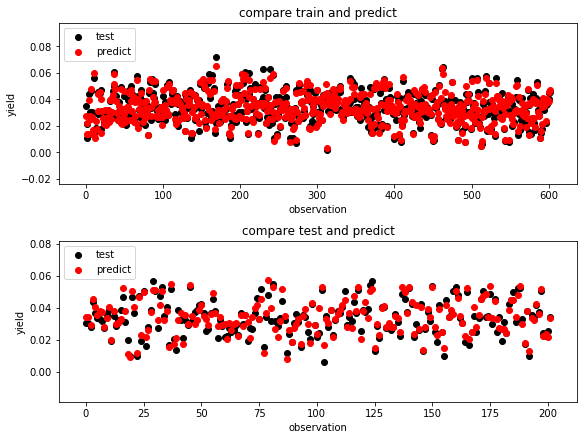

In [14]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG', 'cc']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['extra_parameters'] = ['bollsize', 'bollnum', 'bollvol']

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 500
model_parameters['verbose'] = 1
model_parameters['layer'] = [32]
model_parameters['dampconst'] = 2.7
model_parameters['dampfac'] = 0.02
model_parameters['E_stop'] = 0.005


#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

(805, 62)
(805,)
Iteration:  0 		Error:  245.7984513804824 	scale factor:  0.02
Iteration:  1 		Error:  0.11320701120121486 	scale factor:  0.007407407407407407
Iteration:  2 		Error:  0.10152640706674472 	scale factor:  0.0027434842249657062
Iteration:  3 		Error:  0.07516596342257287 	scale factor:  0.0027434842249657062
Iteration:  4 		Error:  0.05207923059355228 	scale factor:  0.0027434842249657062
Iteration:  5 		Error:  0.032781389080346675 	scale factor:  0.0027434842249657062
Iteration:  6 		Error:  0.024362515619090985 	scale factor:  0.0027434842249657062
Iteration:  7 		Error:  0.023905964613747718 	scale factor:  0.001016105268505817
Iteration:  8 		Error:  0.019972167854070907 	scale factor:  0.001016105268505817
Iteration:  9 		Error:  0.019454510264217777 	scale factor:  0.002743484224965706
Iteration:  10 		Error:  0.019290402961378784 	scale factor:  0.002743484224965706
Iteration:  11 		Error:  0.019145926327546605 	scale factor:  0.002743484224965706
Iteration:  12 

Iteration:  98 		Error:  0.013136846715756873 	scale factor:  0.00037633528463178407
Iteration:  99 		Error:  0.013111245298646587 	scale factor:  0.00037633528463178407
Iteration:  100 		Error:  0.01308648815520929 	scale factor:  0.00037633528463178407
Iteration:  101 		Error:  0.013062531902008002 	scale factor:  0.00037633528463178407
Iteration:  102 		Error:  0.013039335379586656 	scale factor:  0.00037633528463178407
Iteration:  103 		Error:  0.013016860034748513 	scale factor:  0.00037633528463178407
Iteration:  104 		Error:  0.012995070006793417 	scale factor:  0.00037633528463178407
Iteration:  105 		Error:  0.01297393202915552 	scale factor:  0.00037633528463178407
Iteration:  106 		Error:  0.01295341522731672 	scale factor:  0.00037633528463178407
Iteration:  107 		Error:  0.012933490870487592 	scale factor:  0.00037633528463178407
Iteration:  108 		Error:  0.012914132114663355 	scale factor:  0.00037633528463178407
Iteration:  109 		Error:  0.01289531376113395 	scale factor

Iteration:  195 		Error:  0.010252045082217925 	scale factor:  5.162349583426392e-05
Iteration:  196 		Error:  0.010226806873207662 	scale factor:  5.162349583426392e-05
Iteration:  197 		Error:  0.010202105398654925 	scale factor:  5.162349583426392e-05
Iteration:  198 		Error:  0.010178023027217176 	scale factor:  5.162349583426392e-05
Iteration:  199 		Error:  0.010154628905978257 	scale factor:  5.162349583426392e-05
Iteration:  200 		Error:  0.010131975369478078 	scale factor:  5.162349583426392e-05
Iteration:  201 		Error:  0.010110095027671007 	scale factor:  5.162349583426392e-05
Iteration:  202 		Error:  0.01008899917452972 	scale factor:  5.162349583426392e-05
Iteration:  203 		Error:  0.010068677839124168 	scale factor:  5.162349583426392e-05
Iteration:  204 		Error:  0.010049101537304417 	scale factor:  5.162349583426392e-05
Iteration:  205 		Error:  0.01003022463015018 	scale factor:  5.162349583426392e-05
Iteration:  206 		Error:  0.010011989679149794 	scale factor:  5.16

Iteration:  292 		Error:  0.008475770668559528 	scale factor:  5.162349583426392e-05
Iteration:  293 		Error:  0.008462051665745884 	scale factor:  5.162349583426392e-05
Iteration:  294 		Error:  0.008448472602117438 	scale factor:  5.162349583426392e-05
Iteration:  295 		Error:  0.008435026709499218 	scale factor:  5.162349583426392e-05
Iteration:  296 		Error:  0.008421706170512673 	scale factor:  5.162349583426392e-05
Iteration:  297 		Error:  0.008408502027041256 	scale factor:  5.162349583426392e-05
Iteration:  298 		Error:  0.008395404096744035 	scale factor:  5.162349583426392e-05
Iteration:  299 		Error:  0.008382400985911458 	scale factor:  5.162349583426392e-05
Iteration:  300 		Error:  0.008369480158527558 	scale factor:  5.162349583426392e-05
Iteration:  301 		Error:  0.008356628112647065 	scale factor:  5.162349583426392e-05
Iteration:  302 		Error:  0.008343830684907735 	scale factor:  5.162349583426392e-05
Iteration:  303 		Error:  0.008331073481414873 	scale factor:  5.

Iteration:  389 		Error:  0.007279966895510313 	scale factor:  5.162349583426392e-05
Iteration:  390 		Error:  0.007269416728549424 	scale factor:  5.162349583426392e-05
Iteration:  391 		Error:  0.0072587819931652885 	scale factor:  5.162349583426392e-05
Iteration:  392 		Error:  0.007248078591448131 	scale factor:  5.162349583426392e-05
Iteration:  393 		Error:  0.007237323755786548 	scale factor:  5.162349583426392e-05
Iteration:  394 		Error:  0.007226534850799101 	scale factor:  5.162349583426392e-05
Iteration:  395 		Error:  0.007215728323274984 	scale factor:  5.162349583426392e-05
Iteration:  396 		Error:  0.007204919383788054 	scale factor:  5.162349583426392e-05
Iteration:  397 		Error:  0.007194121498735657 	scale factor:  5.162349583426392e-05
Iteration:  398 		Error:  0.007183346500148771 	scale factor:  5.162349583426392e-05
Iteration:  399 		Error:  0.007172604587209986 	scale factor:  5.162349583426392e-05
Iteration:  400 		Error:  0.007161904585317673 	scale factor:  5

Iteration:  486 		Error:  0.005669189772999706 	scale factor:  1.91198132719496e-05
Iteration:  487 		Error:  0.005652137248996424 	scale factor:  1.91198132719496e-05
Iteration:  488 		Error:  0.005635480142921914 	scale factor:  1.91198132719496e-05
Iteration:  489 		Error:  0.005619159234178142 	scale factor:  1.91198132719496e-05
Iteration:  490 		Error:  0.005603126141507167 	scale factor:  1.91198132719496e-05
Iteration:  491 		Error:  0.005587341367360411 	scale factor:  1.91198132719496e-05
Iteration:  492 		Error:  0.005571772612622455 	scale factor:  1.91198132719496e-05
Iteration:  493 		Error:  0.005556393281949684 	scale factor:  1.91198132719496e-05
Iteration:  494 		Error:  0.005541180946476458 	scale factor:  1.91198132719496e-05
Iteration:  495 		Error:  0.005526116753056476 	scale factor:  1.91198132719496e-05
Iteration:  496 		Error:  0.0055111848417190865 	scale factor:  1.91198132719496e-05
Iteration:  497 		Error:  0.005496371811312734 	scale factor:  1.9119813271

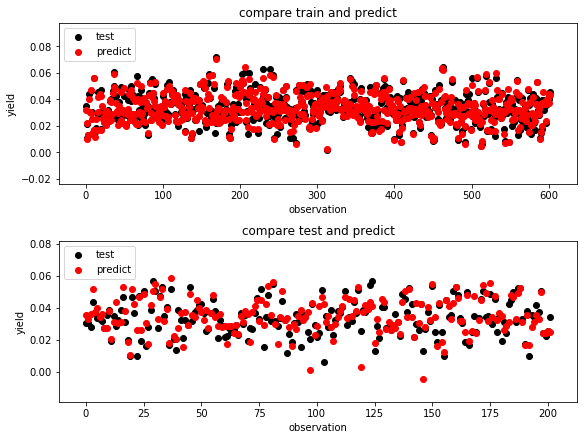

In [15]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG', 'cc']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['extra_parameters'] = []

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 300
model_parameters['verbose'] = 1
model_parameters['layer'] = [32]
model_parameters['dampconst'] = 2.7
model_parameters['dampfac'] = 0.02
model_parameters['E_stop'] = 0.005


#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

(805, 62)
(805,)
Iteration:  0 		Error:  116.80698236432401 	scale factor:  0.02
Iteration:  1 		Error:  0.043965294286295496 	scale factor:  0.007407407407407407
Iteration:  2 		Error:  0.0324889647795944 	scale factor:  0.007407407407407407
Iteration:  3 		Error:  0.029759848289416878 	scale factor:  0.007407407407407407
Iteration:  4 		Error:  0.027961459339879608 	scale factor:  0.007407407407407407
Iteration:  5 		Error:  0.02658639258370418 	scale factor:  0.007407407407407407
Iteration:  6 		Error:  0.025546569891028364 	scale factor:  0.007407407407407407
Iteration:  7 		Error:  0.024754302310417215 	scale factor:  0.007407407407407407
Iteration:  8 		Error:  0.024134319450767196 	scale factor:  0.007407407407407407
Iteration:  9 		Error:  0.02363217827065266 	scale factor:  0.007407407407407407
Iteration:  10 		Error:  0.023211810497280137 	scale factor:  0.007407407407407407
Iteration:  11 		Error:  0.023058591353017036 	scale factor:  0.0027434842249657062
Iteration:  12 		E

Iteration:  99 		Error:  0.0157161152894177 	scale factor:  0.001016105268505817
Iteration:  100 		Error:  0.015714835540404436 	scale factor:  0.00037633528463178407
Iteration:  101 		Error:  0.015642187228103243 	scale factor:  0.00037633528463178407
Iteration:  102 		Error:  0.015572973889010121 	scale factor:  0.00037633528463178407
Iteration:  103 		Error:  0.01550487608312028 	scale factor:  0.00037633528463178407
Iteration:  104 		Error:  0.015437673406874975 	scale factor:  0.00037633528463178407
Iteration:  105 		Error:  0.015371086617337104 	scale factor:  0.00037633528463178407
Iteration:  106 		Error:  0.015304838759240954 	scale factor:  0.00037633528463178407
Iteration:  107 		Error:  0.015238658610917716 	scale factor:  0.00037633528463178407
Iteration:  108 		Error:  0.015172265633306222 	scale factor:  0.00037633528463178407
Iteration:  109 		Error:  0.015105346316198956 	scale factor:  0.00037633528463178407
Iteration:  110 		Error:  0.015037535650785876 	scale factor

Iteration:  196 		Error:  0.01167259766348232 	scale factor:  5.162349583426392e-05
Iteration:  197 		Error:  0.01165208937392573 	scale factor:  5.162349583426392e-05
Iteration:  198 		Error:  0.011629329260047975 	scale factor:  5.162349583426392e-05
Iteration:  199 		Error:  0.01160370569494116 	scale factor:  5.162349583426392e-05
Iteration:  200 		Error:  0.011574359456647084 	scale factor:  5.162349583426392e-05
Iteration:  201 		Error:  0.011540282957569445 	scale factor:  5.162349583426392e-05
Iteration:  202 		Error:  0.011500632261798503 	scale factor:  5.162349583426392e-05
Iteration:  203 		Error:  0.011455196481773339 	scale factor:  5.162349583426392e-05
Iteration:  204 		Error:  0.011404841337953938 	scale factor:  5.162349583426392e-05
Iteration:  205 		Error:  0.011351684148367135 	scale factor:  5.162349583426392e-05
Iteration:  206 		Error:  0.011298809155768032 	scale factor:  5.162349583426392e-05
Iteration:  207 		Error:  0.01124951731248818 	scale factor:  5.1623

Iteration:  293 		Error:  0.009645090143445938 	scale factor:  5.162349583426392e-05
Iteration:  294 		Error:  0.009637459151954438 	scale factor:  5.162349583426392e-05
Iteration:  295 		Error:  0.009629562252961039 	scale factor:  5.162349583426392e-05
Iteration:  296 		Error:  0.00962096218899005 	scale factor:  5.162349583426392e-05
Iteration:  297 		Error:  0.009611235412952763 	scale factor:  5.162349583426392e-05
Iteration:  298 		Error:  0.0096000438489595 	scale factor:  5.162349583426392e-05
Iteration:  299 		Error:  0.009587193423819978 	scale factor:  5.162349583426392e-05
Iteration:  300 		Error:  0.00957266016486431 	scale factor:  5.162349583426392e-05
Maximum number of iterations reached
r2 score =  0.8775170646611886 / 1.0
r2 score =  0.719210159871216 / 1.0


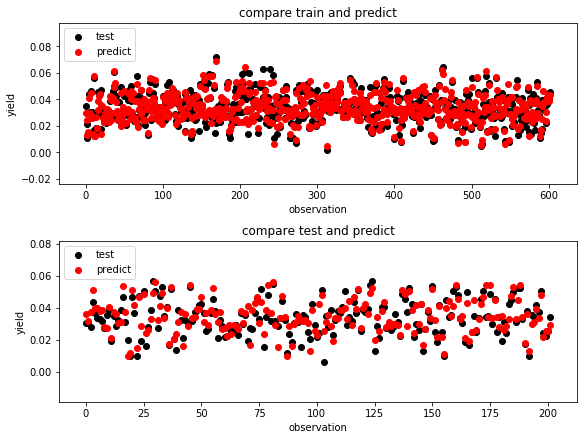

In [16]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG', 'cc']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['extra_parameters'] = []

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 300
model_parameters['verbose'] = 1
model_parameters['layer'] = [32]
model_parameters['dampconst'] = 2.7
model_parameters['dampfac'] = 0.02
model_parameters['E_stop'] = 0.005


#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

(805, 1)
(805, 1)
(805, 1)
(805, 65)
(805,)
Iteration:  0 		Error:  22.862179713502293 	scale factor:  0.02
Iteration:  1 		Error:  0.11331594384799899 	scale factor:  0.007407407407407407
Iteration:  2 		Error:  0.038558370692431704 	scale factor:  0.0027434842249657062
Iteration:  3 		Error:  0.01890620468734929 	scale factor:  0.0027434842249657062
Iteration:  4 		Error:  0.016718012519196166 	scale factor:  0.0027434842249657062
Iteration:  5 		Error:  0.016364523685239357 	scale factor:  0.0027434842249657062
Iteration:  6 		Error:  0.016113642360545282 	scale factor:  0.0027434842249657062
Iteration:  7 		Error:  0.015732345011631937 	scale factor:  0.0027434842249657062
Iteration:  8 		Error:  0.015239095250365427 	scale factor:  0.0027434842249657062
Iteration:  9 		Error:  0.01471301846512892 	scale factor:  0.0027434842249657062
Iteration:  10 		Error:  0.014231300323177818 	scale factor:  0.0027434842249657062
Iteration:  11 		Error:  0.013834928549245175 	scale factor:  0.0

Iteration:  98 		Error:  0.008250359920617107 	scale factor:  0.0001393834387525126
Iteration:  99 		Error:  0.008210724328155044 	scale factor:  0.0001393834387525126
Iteration:  100 		Error:  0.008173230145797765 	scale factor:  0.0001393834387525126
Iteration:  101 		Error:  0.008138074900844922 	scale factor:  0.0001393834387525126
Iteration:  102 		Error:  0.008105301533225891 	scale factor:  0.0001393834387525126
Iteration:  103 		Error:  0.008074756078243922 	scale factor:  0.0001393834387525126
Iteration:  104 		Error:  0.008046131766169588 	scale factor:  0.0001393834387525126
Iteration:  105 		Error:  0.008019057452025477 	scale factor:  0.0001393834387525126
Iteration:  106 		Error:  0.007993185732379391 	scale factor:  0.0001393834387525126
Iteration:  107 		Error:  0.007968249770629533 	scale factor:  0.0001393834387525126
Iteration:  108 		Error:  0.007944079062669597 	scale factor:  0.0001393834387525126
Iteration:  109 		Error:  0.007920583238339898 	scale factor:  0.00

Iteration:  195 		Error:  0.006062580896101088 	scale factor:  5.162349583426392e-05
Iteration:  196 		Error:  0.0060372142355303434 	scale factor:  5.162349583426392e-05
Iteration:  197 		Error:  0.0060113101906948 	scale factor:  5.162349583426392e-05
Iteration:  198 		Error:  0.005985786081362346 	scale factor:  5.162349583426392e-05
Iteration:  199 		Error:  0.005961302138708123 	scale factor:  5.162349583426392e-05
Iteration:  200 		Error:  0.005938196870641284 	scale factor:  5.162349583426392e-05
Iteration:  201 		Error:  0.005916539615957807 	scale factor:  5.162349583426392e-05
Iteration:  202 		Error:  0.0058962308848161836 	scale factor:  5.162349583426392e-05
Iteration:  203 		Error:  0.005877096882344075 	scale factor:  5.162349583426392e-05
Iteration:  204 		Error:  0.005858954954158004 	scale factor:  5.162349583426392e-05
Iteration:  205 		Error:  0.005841648405273267 	scale factor:  5.162349583426392e-05
Iteration:  206 		Error:  0.005825059012607894 	scale factor:  5.

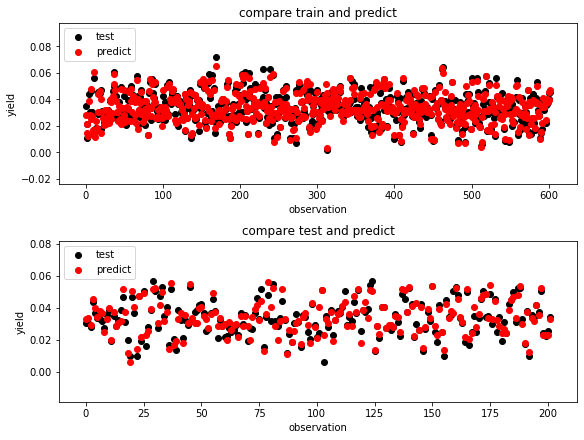

In [17]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG', 'cc']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['extra_parameters'] = ['bollsize', 'bollnum', 'bollvol']

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 300
model_parameters['verbose'] = 1
model_parameters['layer'] = [32]
model_parameters['dampconst'] = 2.7
model_parameters['dampfac'] = 0.02
model_parameters['E_stop'] = 0.005


#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

Iteration:  0 		Error:  656.8210447233082 	scale factor:  0.1
Iteration:  1 		Error:  15.191983258470394 	scale factor:  0.02
Iteration:  2 		Error:  0.1805234213882162 	scale factor:  0.004
Iteration:  3 		Error:  0.0626615841885774 	scale factor:  0.004
Iteration:  4 		Error:  0.029634290122055547 	scale factor:  0.004
Iteration:  5 		Error:  0.022307637632760897 	scale factor:  0.004
Iteration:  6 		Error:  0.02031458828647621 	scale factor:  0.004
Iteration:  7 		Error:  0.019591714023535295 	scale factor:  0.004
Iteration:  8 		Error:  0.01922685918269705 	scale factor:  0.004
Iteration:  9 		Error:  0.018988060422322768 	scale factor:  0.004
Iteration:  10 		Error:  0.01880486390035995 	scale factor:  0.004
Iteration:  11 		Error:  0.01865151495680746 	scale factor:  0.004
Iteration:  12 		Error:  0.018516915248214954 	scale factor:  0.004
Iteration:  13 		Error:  0.018395596552494134 	scale factor:  0.004
Iteration:  14 		Error:  0.01828455974381797 	scale factor:  0.004
Iterati

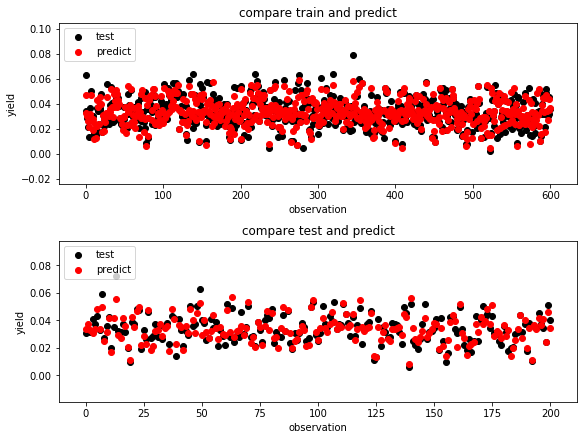

In [293]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['extra_parameters'] = ['bollvol', 'bollnum', 'bollsize']

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 50
model_parameters['verbose'] = 1
model_parameters['layer'] = [32, 32]
model_parameters['dampconst'] = 5
model_parameters['dampfac'] = 0.1
model_parameters['E_stop'] = 0.005
#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

In [ ]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG', 'NDVI']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105

model_parameters['k_max'] = 20
model_parameters['layer'] = [32, 32]
#data Type
data_func = cottonYieldDataAkash

akashProcess(model_parameters, data_parameters, data_func)

In [223]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG', 'NDVI']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['extra_parameters'] = []
data_parameters['one_hot_encoded_parameters'] = []
model_parameters['k_max'] = 20
model_parameters['layer'] = [32, 32]
#data Type
data_func = cottonYieldData
x_data, y_data, x_normalization_mask, y_normalization_mask = cottonYieldData(data_parameters)
x_data_2, y_data_2, x_normalization_mask, y_normalization_mask = cottonYieldDataAkash(data_parameters)

In [224]:
mask = np.isin(x_data, x_data_2)
print(sum(mask))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [234]:
a = np.array([0.221639 ,0.401311, 0.358033, 0.34623, 0.385574, 0.445902, 0.347541, 0.250492, 0.45377, 0.333115])
b = np.array([3.78, 6.52, 5.86, 5.68, 6.28, 7.2, 5.7, 4.22, 7.32, 5.48])

In [235]:
c = b/a

In [236]:
c

array([17.05476022, 16.24675127, 16.36720637, 16.40527973, 16.28740527,
       16.14704576, 16.40094262, 16.84684541, 16.13152037, 16.45077526])

In [15]:
#build model that have 2 hidden layers (64, 64)
def buildRegressionModel(model_shape, input_shape, optimizer, loss, metrics, drop_out=None, regularizer_l1=None, regularizer_l2=None, kernel_initializer = 'uniform', drop_out_rate = 0.25):

    # Define a Keras sequential model
    model = keras.Sequential()
    # Define the first dense layer
    for (i, size) in enumerate(model_shape):
        if i ==0:
            model.add(keras.layers.Dense(size, activation='relu', input_shape=[input_shape], kernel_regularizer=regularizer_l2,
                        activity_regularizer=regularizer_l1, kernel_initializer=kernel_initializer))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
        else:
            model.add(keras.layers.Dense(size, activation='relu', kernel_regularizer=regularizer_l2, kernel_initializer=kernel_initializer,
                        activity_regularizer=regularizer_l1))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
    model.add(keras.layers.Dense(1, kernel_initializer=kernel_initializer))
    
    #compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [16]:
def trainModel(x_data, y_data, input_shape, parameters):    
    #Build Hypterparameter
    sizes = parameters['sizes'] 
    shapes = parameters['shapes']
    drop_out = parameters['drop_out'] 
    regularizer_l1 = parameters['regularizer_l1']
    regularizer_l2 = parameters['regularizer_l2']
    kernel_initializer = parameters['kernel_initializer']
    drop_out_rate = parameters['drop_out_rate']
    #Compile Hyperparameter
    optimizer = parameters['optimizer']
    #optimizer = keras.optimizers.RMSprop(0.001)
    loss = parameters['loss']
    #loss = 'mae'
    metrics = parameters['metrics']

    #Callback Hyperparameter
    early_stopping = parameters['early_stopping']
    if early_stopping:
        callbacks = [early_stopping]
    else:
        callbacks = None
    verbose = parameters['verbose']
    
    #Train Hyperparameter
    epochs = parameters['epochs']
    validation_split = parameters['validation_split'] 
    
    #Test Train Split
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state = 90)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state = 90)
    
    histories ={}
    models = {}
    #build and train model
    for (i, size) in enumerate(sizes):
        models[size] = buildRegressionModel(shapes[i], input_shape, optimizer, loss, metrics, drop_out = drop_out, kernel_initializer = kernel_initializer, 
                                     regularizer_l1=regularizer_l1, regularizer_l2 =regularizer_l2)
        histories[size] = models[size].fit(x_train, y_train, epochs=epochs, validation_data=(x_valid, y_valid), 
                                  callbacks = callbacks, verbose = verbose)
        
        
    #plot results
    colors = ['red', 'blue', 'green', 'yellow']
    plt.figure()
    for i, size in enumerate(sizes):
        data_history = histories[size].history
        loss = data_history['loss']
        val_loss = data_history['val_loss']
        plt.plot(val_loss, color=colors[i], linestyle = '--', label = size + '_val_loss')
        plt.plot(loss, color=colors[i], linestyle = ':', label = size +'_loss')
    
    plt.legend(loc = 'upper left' )
    plt.xlabel = 'epochs'
    plt.ylabel = 'loss'
    
    
    #Show R2 scores
    for i, size in enumerate(sizes):
        #train score
        pred_train = models[size].predict(x_train)
        train_compare = pd.DataFrame({'y_train': y_train.flatten(), 'y_train_pred': pred_train.flatten()})
        train_r2_score = r2_score(train_compare.y_train, train_compare.y_train_pred)
        print(size + ' train r2 score = ', train_r2_score, '/ 1.0')
        
        #test score
        pred_test = models[size].predict(x_test)
        test_compare = pd.DataFrame({'y_test': y_test.flatten(), 'y_test_pred': pred_test.flatten()})
        test_r2_score = r2_score(test_compare.y_test, test_compare.y_test_pred)
        print(size+' test r2 score = ', test_r2_score, '/ 1.0')
        
    return (models, histories)

(805, 1)
(805, 1)
(805, 1)
(805, 65)
(805,)
default train r2 score =  0.9199341742669676 / 1.0
default test r2 score =  0.7755047953274891 / 1.0
medium train r2 score =  0.905688606738722 / 1.0
medium test r2 score =  0.7958497692757764 / 1.0
small train r2 score =  0.84793877879038 / 1.0
small test r2 score =  0.7661709611553781 / 1.0
tiny train r2 score =  0.8804604833630608 / 1.0
tiny test r2 score =  0.8031308315279647 / 1.0


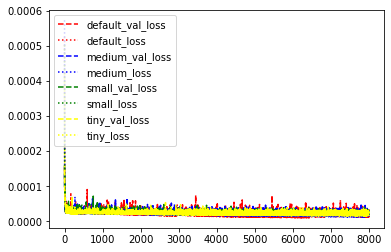

In [21]:
parameters = {}    
#Build Hypterparameter
parameters['sizes'] = ['default', 'medium', 'small', 'tiny']
# parameters['sizes'] = ['default', 'medium']
parameters['shapes'] = [[64,64,64,64], [64,64, 64], [64, 64], [64]]
# parameters['shapes'] = [[16,16]]
parameters['drop_out'] = False
parameters['regularizer_l1'] = None
parameters['regularizer_l2'] = None
parameters['kernel_initializer'] = 'uniform'
parameters['drop_out_rate'] = 0.001

#Compile Hyperparameter
parameters['optimizer'] = 'adam'
# parameters['optimizer'] = keras.optimizers.RMSprop(0.001)
parameters['loss'] = 'mse'
#loss = 'mae'
parameters['metrics'] = ['mse']

#Callback Hyperparameter
parameters['monitor'] = 'val_loss'
parameters['min_delta'] = 0.0001
parameters['patience'] = 1000
parameters['mode'] = 'min'
parameters['verbose'] = 0
parameters['restore_best_weights'] = True
# parameters['early_stopping'] = EarlyStopping(monitor=parameters['monitor'], min_delta=parameters['min_delta'], patience=parameters['patience'], mode=parameters['mode'], verbose=parameters['verbose'] , restore_best_weights = parameters['restore_best_weights'])
parameters['early_stopping'] = None

#Train Hyperparameter
parameters['epochs'] = 8000
parameters['validation_split'] = 0.2

data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['date_chosen'] = ''
data_parameters['grnn'] = True
data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['remove_bad_yield'] = False
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG', 'cc']
data_parameters['extra_parameters'] = ['bollvol', 'bollnum', 'bollsize']
data_parameters['one_hot_encoded_parameters'] = ['irrigation']

#data Type
data_func = cottonYieldData

models, histories = process(parameters, data_parameters, data_func)

In [241]:
parameters = {}    
#Build Hypterparameter
parameters['sizes'] = ['default', 'medium', 'small', 'tiny']
# parameters['sizes'] = ['default', 'medium']
parameters['shapes'] = [[64,64,64,64], [64,64], [64], [64,64,64,64]]
# parameters['shapes'] = [[16,16]]
parameters['drop_out'] = False
parameters['regularizer_l1'] = None
parameters['regularizer_l2'] = None
parameters['kernel_initializer'] = 'uniform'
parameters['drop_out_rate'] = 0.001

#Compile Hyperparameter
parameters['optimizer'] = 'adam'
# parameters['optimizer'] = keras.optimizers.RMSprop(0.001)
parameters['loss'] = 'mse'
#loss = 'mae'
parameters['metrics'] = ['mse']

#Callback Hyperparameter
parameters['monitor'] = 'val_loss'
parameters['min_delta'] = 0.0001
parameters['patience'] = 1000
parameters['mode'] = 'min'
parameters['verbose'] = 0
parameters['restore_best_weights'] = True
# parameters['early_stopping'] = EarlyStopping(monitor=parameters['monitor'], min_delta=parameters['min_delta'], patience=parameters['patience'], mode=parameters['mode'], verbose=parameters['verbose'] , restore_best_weights = parameters['restore_best_weights'])
parameters['early_stopping'] = None

#Train Hyperparameter
parameters['epochs'] = 4000
parameters['validation_split'] = 0.2

data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['date_chosen'] = ''
data_parameters['grnn'] = True
data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['remove_bad_yield'] = False
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG', 'NDVI']
data_parameters['extra_parameters'] = ['bollvol', 'bollnum', 'bollsize']
data_parameters['one_hot_encoded_parameters'] = ['irrigation']

#data Type
data_func = cottonYieldData

models, histories = process(parameters, data_parameters, data_func)

(805, 65)
(805,)


KeyboardInterrupt: 

(805, 1)
(805, 1)
(805, 1)
(805, 65)
(805,)
default train r2 score =  0.8749369235064256 / 1.0
default test r2 score =  0.8074856651682788 / 1.0
medium train r2 score =  0.8661783864536009 / 1.0
medium test r2 score =  0.8171178774787506 / 1.0
small train r2 score =  0.8587438158532718 / 1.0
small test r2 score =  0.8077575638257051 / 1.0
tiny train r2 score =  0.8598550657624184 / 1.0
tiny test r2 score =  0.8058844531469987 / 1.0


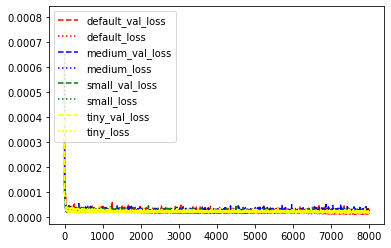

In [20]:
parameters = {}    
#Build Hypterparameter
parameters['sizes'] = ['default', 'medium', 'small', 'tiny']
# parameters['sizes'] = ['default', 'medium']
parameters['shapes'] = [[32,32,32,32], [32,32], [32], [10]]
# parameters['shapes'] = [[16,16]]
parameters['drop_out'] = False
parameters['regularizer_l1'] = None
parameters['regularizer_l2'] = None
parameters['kernel_initializer'] = 'uniform'
parameters['drop_out_rate'] = 0.001

#Compile Hyperparameter
parameters['optimizer'] = 'adam'
# parameters['optimizer'] = keras.optimizers.RMSprop(0.001)
parameters['loss'] = 'mse'
#loss = 'mae'
parameters['metrics'] = ['mse']

#Callback Hyperparameter
parameters['monitor'] = 'val_loss'
parameters['min_delta'] = 0.0001
parameters['patience'] = 1000
parameters['mode'] = 'min'
parameters['verbose'] = 0
parameters['restore_best_weights'] = True
# parameters['early_stopping'] = EarlyStopping(monitor=parameters['monitor'], min_delta=parameters['min_delta'], patience=parameters['patience'], mode=parameters['mode'], verbose=parameters['verbose'] , restore_best_weights = parameters['restore_best_weights'])
parameters['early_stopping'] = None

#Train Hyperparameter
parameters['epochs'] = 8000
parameters['validation_split'] = 0.2

data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['date_chosen'] = ''
data_parameters['grnn'] = True
data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['remove_bad_yield'] = False
data_parameters['file_parameters'] = ['ch', 'cv', 'ExG', 'cc']
data_parameters['extra_parameters'] = ['bollvol', 'bollnum', 'bollsize']
data_parameters['one_hot_encoded_parameters'] = ['irrigation']

#data Type
data_func = cottonYieldData

models, histories = process(parameters, data_parameters, data_func)